## 迁移学习

### 载入数据

In [2]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(66)

train_data = []
test_data = []

# #------- single pre-trained mode
# with h5py.File('ResNet50_pre_out.h5', 'r') as h:
#     train_data.append(np.array(h['train']))
#     train_labels = np.array(h['label'])
#     test_data.append(np.array(h['test']))

#-------- composite mode 
for filename in ['ResNet50_pre_out.h5', 'Xception_pre_out.h5', 'InceptionV3_pre_out.h5']:
    with h5py.File(filename) as h:
        train_data.append(np.array(h['train']))
        train_labels = np.array(h['label'])
        test_data.append(np.array(h['test']))

train_data = np.concatenate(train_data, axis=1)
test_data = np.concatenate(test_data, axis=1)

print("train shape:",train_data.shape)
print("train_data:",train_data[:5])
# 预存的X_train, y_train是按顺序存放的，前12500是猫，后12500是狗, 这里打乱顺序，使之随机存放
# Note: 打乱的是存放存放顺序，并不改变 X_train , y_train的对应关系
train_data, train_labels = shuffle(train_data, train_labels)

train shape: (25000, 6144)
train_data: [[1.3793691  0.3200359  1.0971487  ... 0.02197148 0.         1.056223  ]
 [0.30272076 0.76675266 0.04666634 ... 0.         0.         1.57221   ]
 [0.05970082 0.         0.01757717 ... 0.         0.         2.951519  ]
 [1.6001272  0.02581474 0.08697932 ... 0.         0.33145148 1.3846457 ]
 [0.         0.26336735 0.06699894 ... 0.         0.         1.6271708 ]]


### 构建模型

In [3]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input

# from keras.applications import xception
input_tensor=Input(train_data.shape[1:])

model = Sequential()
model.add(Flatten(input_tensor))
model.add(Dense(1, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


AttributeError: 'Tensor' object has no attribute 'lower'

In [4]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
import numpy as np

np.random.seed(66)

input_tensor = Input(train_data.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 在pre-train features上训练模型

In [5]:
model_hist = model.fit(train_data, train_labels,
                       batch_size=128,epochs=8,
                       validation_split = 0.2,
                       verbose=1
          )

model.save('log/model_x3.h5')
with open('log/model_x3_hist.txt','w') as f:
    f.write(str(model_hist.history))

Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 17s 831us/step - loss: 3.6232 - acc: 0.6777 - val_loss: 2.8528 - val_acc: 0.7356
Epoch 2/8
20000/20000 [==============================] - 8s 390us/step - loss: 1.6813 - acc: 0.8302 - val_loss: 0.9379 - val_acc: 0.8928
Epoch 3/8
20000/20000 [==============================] - 12s 582us/step - loss: 0.8015 - acc: 0.9064 - val_loss: 0.3747 - val_acc: 0.9426
Epoch 4/8
20000/20000 [==============================] - 9s 428us/step - loss: 0.5164 - acc: 0.9333 - val_loss: 0.7370 - val_acc: 0.9032
Epoch 5/8
20000/20000 [==============================] - 7s 335us/step - loss: 0.5195 - acc: 0.9321 - val_loss: 0.1845 - val_acc: 0.9704
Epoch 6/8
20000/20000 [==============================] - 5s 243us/step - loss: 0.4873 - acc: 0.9356 - val_loss: 0.2693 - val_acc: 0.9564
Epoch 7/8
20000/20000 [==============================] - 10s 480us/step - loss: 0.3862 - acc: 0.9469 - val_loss: 0.2709 - val_a

/home/jerry/.local/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


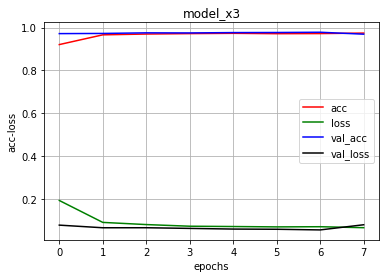

In [7]:
## 查看 history
import matplotlib.pyplot as plt

def read_history_from_file(filename):
    f = open(filename,'r')
    rdbuf = f.read()
    hist = eval(rdbuf)
    f.close()
    
    return hist

def show_history(hist, title_name):
    # epoch as x-axis 
    epochs = range(len(hist['acc']))
    
    fig, ax = plt.subplots()
    
    # acc
    ax.plot(epochs, hist['acc'], 'r', label='acc')
    # loss
    ax.plot(epochs, hist['loss'], 'g', label='loss')
    # val_acc
    ax.plot(epochs, hist['val_acc'], 'b', label='val_acc')
    # val_loss
    ax.plot(epochs, hist['val_loss'], 'k', label='val_loss')
    
    ax.set(xlabel='epochs', ylabel='acc-loss',title=title_name)
    
    ax.legend(loc='best', fancybox=True, fontsize=10)
            
    ax.grid(True)
    
    fig.show()
    
hist = read_history_from_file('log/model_hist.txt')
# print(hist)
show_history(hist, 'model_x3')

### 用拟合后的模型预测

In [8]:
y_pred = model.predict(test_data, verbose=1)

12500/12500 [==============================] - 3s 262us/step


预测结果写入kaggle sample_submission.csv

In [9]:
y_pred = y_pred.clip(min=0.005, max=0.995)

import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("pre-test", (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


/home/jerry/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


### 模型可视化

In [1]:
from graphviz import Digraph

dot = Digraph(comment='The Model Chart')

dot.attr('node',shape='record')

dot.node('IN', 'Input|images')
dot.node('PRE-R', 'ResNet50|{input:|output:}|{(224, 224, 3)|(2048)}')
dot.node('PRE-X', 'Xception|{input:|output:}|{(299, 299, 3)|(2048)}')
dot.node('PRE-I', 'InceptionV3|{input:|output:}|{(299, 299, 3)|(2048)}')
dot.edge('IN', 'PRE-R')
dot.edge('IN', 'PRE-X')
dot.edge('IN', 'PRE-I')
# dot.edges(['AB', 'AL'])
# dot.edge('PRE-R', 'PRE-X', constraint='false')

dot.node('L3', 'Flatten|{input:|output:}|{(2048,3)|2048*3=6144}')
dot.edge('PRE-R', 'L3')
dot.edge('PRE-X', 'L3')
dot.edge('PRE-I', 'L3')

dot.node('L4', 'Dropout|Rate:|0.5')
dot.node('L5', 'Output|{input:|output:}|{6144|1}')
dot.edge('L3', 'L4')
dot.edge('L4', 'L5')

print(dot.source)
dot.render('model-table.gv', view=True)

// The Model Chart
digraph {
	node [shape=record]
	IN [label="Input|images"]
	"PRE-R" [label="ResNet50|{input:|output:}|{(224, 224, 3)|(2048)}"]
	"PRE-X" [label="Xception|{input:|output:}|{(299, 299, 3)|(2048)}"]
	"PRE-I" [label="InceptionV3|{input:|output:}|{(299, 299, 3)|(2048)}"]
	IN -> "PRE-R"
	IN -> "PRE-X"
	IN -> "PRE-I"
	L3 [label="Flatten|{input:|output:}|{(2048,3)|2048*3=6144}"]
	"PRE-R" -> L3
	"PRE-X" -> L3
	"PRE-I" -> L3
	L4 [label="Dropout|Rate:|0.5"]
	L5 [label="Output|{input:|output:}|{6144|1}"]
	L3 -> L4
	L4 -> L5
}


'model-table.gv.pdf'